# Continuous Pendulum Control
Zero reward is the best condition for the pendulum control

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from mvp.env_pendulum import PendulumEnv

from itertools import count
import torch
import gym
from gym.envs.registration import register

import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pendulum Control Gym

## Description
The inverted pendulum swingup problem is a classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, with the other end being free. The pendulum starts in a random position, and the goal is to apply torque to the free end to swing it into an upright position, where its center of gravity is right above the fixed point.

### Pendulum Coordinate System

- **x-y**: Cartesian coordinates of the pendulum’s end in meters.
- **theta**: Angle in radians.
- **tau**: Torque in N·m, defined as positive counter-clockwise.

### Action Space
The action is an ndarray with shape `(1,)` representing the torque applied to the free end of the pendulum.

| Num | Action | Min | Max |
|-----|--------|-----|-----|
| 0   | Torque | -2.0| 2.0 |

### Observation Space
The observation is an ndarray with shape `(3,)` representing the x-y coordinates of the pendulum’s free end and its angular velocity.

| Num | Observation      | Min | Max |
|-----|------------------|-----|-----|
| 0   | x = cos(theta)   | -1.0| 1.0 |
| 1   | y = sin(theta)   | -1.0| 1.0 |
| 2   | Angular Velocity | -8.0| 8.0 |

### Rewards
The reward function is defined as:

$r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)$

where `theta` is the pendulum’s angle normalized between `[-pi, pi]` (with 0 being in the upright position). The minimum reward that can be obtained is `-(pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044`, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

In [9]:
register(
    id='Pendulum-v0',
    entry_point='mvp.env_pendulum:PendulumEnv',
    max_episode_steps=1000)
env = gym.make('Pendulum-v0')

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Pendulum-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [10]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [11]:
env.reward_range

(-inf, inf)

In [12]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

# Evaluation of Model

KL Divergence on Policy (probabilistic distribution of actions outputted by our model) is very important

## PPO

In [14]:
from mvp.ppo_continuous import ActorCritic

path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_ppo_1000_KL_0.01.pth")

env = PendulumEnv(render_mode="human")
n_actions = env.action_space.shape[0]
state, info = env.reset()
n_observations = len(state)
num_eval_episodes = 10

model = ActorCritic(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

for i_episode in range(num_eval_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        env.render()
        # Get action from the model (assuming it outputs action_mean, action_std, and value)
        with torch.no_grad():
            action_mean, _, _ = model(state)
        
        # Take the mean action (no sampling here for deterministic behavior)
        action = action_mean.cpu().numpy()[0]
        print(action)

        observation, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            print(f"Episode finished after {t+1} timesteps")
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
env.close()

[-6.7175508]
[-6.696766]
[-6.584286]
[-6.371494]
[-6.0470963]
[-5.6033983]
[-5.0459137]
[-4.4003143]
[-3.7097847]
[-3.0233777]
[-2.3839266]
[-1.8219794]
[-1.3237442]
[-0.84708273]
[-0.40237668]
[0.00646503]
[0.3819053]
[0.73101634]
[1.0626532]
[1.3845668]
[1.7013952]
[2.0138173]
[2.318623]
[2.616893]
[2.8929822]
[3.1155498]
[3.2471564]
[3.2605526]
[3.145798]
[2.907574]
[2.560491]
[2.1248302]
[1.6221758]
[1.060235]
[0.45641047]
[-0.161497]
[-0.76507956]
[-1.3357865]
[-1.8680681]
[-2.3640883]
[-2.886635]
[-3.4533749]
[-4.0469427]
[-4.641364]
[-5.206813]
[-5.713978]
[-6.1385074]
[-6.4655485]
[-6.691627]
[-6.8209705]
[-6.858926]
[-6.807225]
[-6.661421]
[-6.4098177]


KeyboardInterrupt: 

## FMPPO

Some how just constantly swings around, but does show fast convergence

In [7]:
from mvp.fmppo_continuous import ActorCriticUPN

path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_fmppo_1000_KL_0.01.pth")

env = PendulumEnv(render_mode="human")
n_actions = env.action_space.shape[0]
state, _ = env.reset()
n_observations = len(state)
num_eval_episodes = 10

# Create and load the model
model = ActorCriticUPN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

for i_episode in range(num_eval_episodes):
    state, _ = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    for t in count():
        env.render()
        # Get action from the model
        with torch.no_grad():
            action_mean, _, _ = model(state)
        
        # Take the mean action (no sampling here for deterministic behavior)
        action = action_mean.cpu().numpy()[0]
        print(action)

        next_state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            print(f"Episode finished after {t+1} timesteps")
            break

        state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        
env.close()

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Pendulum-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


[-9.895714]
[-9.785736]
[-9.684856]
[-9.581505]
[-9.47747]
[-9.412632]
[-9.3894615]
[-9.382968]
[-9.393896]
[-9.408569]
[-9.42642]
[-9.443143]
[-9.4587]
[-9.470046]
[-9.478703]
[-9.490932]
[-9.525056]
[-9.573448]
[-9.6417885]
[-9.712595]
[-9.812385]
[-9.9074745]
[-9.981562]
[-10.043621]
[-10.094258]
[-10.13043]
[-10.153189]
[-10.163618]
[-10.163091]
[-10.152272]
[-10.1307955]
[-10.095875]
[-10.046556]
[-9.980419]
[-9.889956]
[-9.780218]
[-9.679272]
[-9.575677]
[-9.472855]
[-9.410381]
[-9.38887]
[-9.382745]
[-9.394615]
[-9.409592]
[-9.42737]
[-9.444109]
[-9.459443]
[-9.470547]
[-9.479142]
[-9.492352]
[-9.527269]
[-9.57641]
[-9.64587]
[-9.716688]
[-9.818296]
[-9.912061]
[-9.98514]
[-10.046731]
[-10.09659]
[-10.132055]
[-10.154071]
[-10.163869]
[-10.162749]
[-10.151394]
[-10.129237]
[-10.093483]
[-10.04343]
[-9.976099]
[-9.884104]
[-9.774822]
[-9.67364]
[-9.569813]
[-9.468815]
[-9.408212]
[-9.38829]
[-9.382748]
[-9.39534]
[-9.410608]
[-9.428316]
[-9.445064]
[-9.460173]
[-9.471033]
[-9.479

KeyboardInterrupt: 

## DQN

In [ ]:
from mvp.dqn_networks import DQN

path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_dqn_discrete_retrain.pth")

env = PendulumEnv(render_mode="human")
ACTION_MAP = np.linspace(-2, 2, 5)  # 5 actions ranging from -2 to 2
n_actions = len(ACTION_MAP)
state, info = env.reset()
n_observations = len(state)

model = DQN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

num_eval_episodes = 10
for i_episode in range(num_eval_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        env.render()

        action_idx = model(state).max(1)[1]
        actual_action = ACTION_MAP[action_idx.item()]
        print(action)

        observation, reward, terminated, truncated, _ = env.step([actual_action])
        if terminated or truncated:
            print(f"Episode finished after {t+1} timesteps")
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
env.close()

## Reward

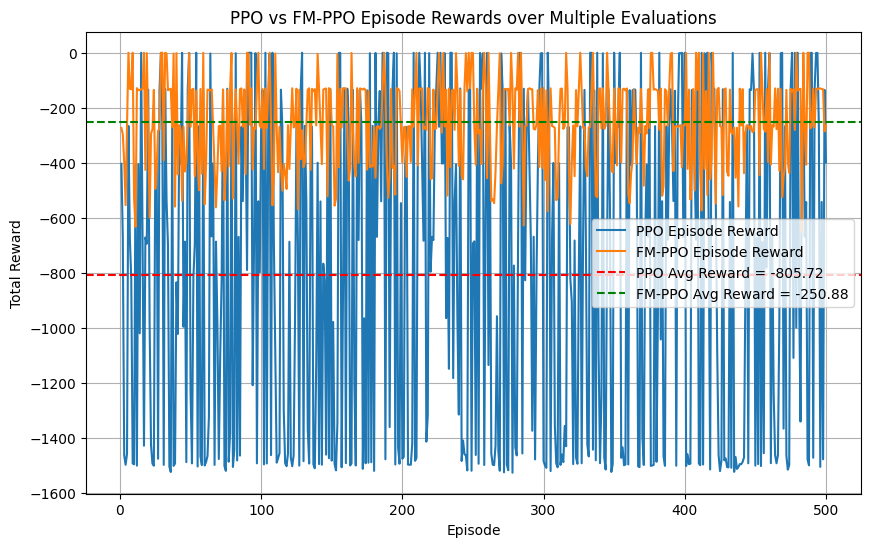

: 

In [11]:
from mvp.ppo_continuous import ActorCritic  # PPO Model
from mvp.fmppo_continuous import ActorCriticUPN  # FM-PPO Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters for evaluation
num_eval_episodes = 500  # Number of episodes for evaluation
max_timesteps = 200  # Max timesteps per episode

# Function to evaluate a model and collect rewards
def evaluate_model(model, env, num_eval_episodes, max_timesteps):
    all_rewards = []
    model.eval()  # Set the model to evaluation mode

    for i_episode in range(num_eval_episodes):
        state, _ = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        episode_rewards = 0

        for t in range(max_timesteps):
            with torch.no_grad():
                action_mean, _, _ = model(state)

            # Take the mean action (no sampling for deterministic behavior)
            action = action_mean.cpu().numpy()[0]

            # Step the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_rewards += reward

            if terminated or truncated:
                break

            state = torch.FloatTensor(next_state).unsqueeze(0).to(device)

        all_rewards.append(episode_rewards)

    return all_rewards

# Load the PPO model
ppo_model_path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_ppo.pth")
ppo_model = ActorCritic(n_states=len(env.reset()[0]), n_actions=env.action_space.shape[0]).to(device)
ppo_model.load_state_dict(torch.load(ppo_model_path, map_location=device))

# Load the FM-PPO model (with UPN)
fmppo_model_path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_fmppo.pth")
fmppo_model = ActorCriticUPN(n_states=len(env.reset()[0]), n_actions=env.action_space.shape[0]).to(device)
fmppo_model.load_state_dict(torch.load(fmppo_model_path, map_location=device))

# Set up the environment (without rendering)
env = PendulumEnv(render_mode=None)

# Evaluate PPO Model
ppo_rewards = evaluate_model(ppo_model, env, num_eval_episodes, max_timesteps)

# Evaluate FM-PPO Model (UPN-based)
fmppo_rewards = evaluate_model(fmppo_model, env, num_eval_episodes, max_timesteps)

# Calculate average rewards for both models
average_ppo_reward = sum(ppo_rewards) / num_eval_episodes
average_fmppo_reward = sum(fmppo_rewards) / num_eval_episodes

# Plot the rewards for both models
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_eval_episodes + 1), ppo_rewards, label="PPO Episode Reward")
plt.plot(range(1, num_eval_episodes + 1), fmppo_rewards, label="FM-PPO Episode Reward")
plt.axhline(y=average_ppo_reward, color='r', linestyle='--', label=f'PPO Avg Reward = {average_ppo_reward:.2f}')
plt.axhline(y=average_fmppo_reward, color='g', linestyle='--', label=f'FM-PPO Avg Reward = {average_fmppo_reward:.2f}')
plt.title("PPO vs FM-PPO Episode Rewards over Multiple Evaluations")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid()
plt.show()